# Neuroevolution on EvoGym

## Getting started

Check that the following line can run. If so, you have evogym installed! Otherwise, you need to install it.

In [1]:
from evogym import sample_robot
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import animation
import gymnasium as gym
import evogym.envs
from evogym import sample_robot
from evogym.utils import get_full_connectivity
from tqdm import tqdm
import ray
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ribs.archives import GridArchive
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler

/Users/massimodebellisvitti/Desktop/Algorithme evolutionnaire/evolution/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-05 11:57:34,791	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Agent

In [2]:
class Network(nn.Module):
    def __init__(self, n_in, h_size, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, n_out)
 
        self.n_out = n_out

    def reset(self):
        pass
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x

In [3]:
class Agent:
    def __init__(self, Net, config, genes = None):
        self.config = config
        self.Net = Net
        self.model = None
        self.fitness = None

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

        self.make_network()
        if genes is not None:
            self.genes = genes

    def __repr__(self):  # pragma: no cover
        return f"Agent {self.model} > fitness={self.fitness}"

    def __str__(self):  # pragma: no cover
        return self.__repr__()

    def make_network(self):
        n_in = self.config["n_in"]
        h_size = self.config["h_size"]
        n_out = self.config["n_out"]
        self.model = self.Net(n_in, h_size, n_out).to(self.device).double()
        return self

    @property
    def genes(self):
        if self.model is None:
            return None
        with torch.no_grad():
            params = self.model.parameters()
            vec = torch.nn.utils.parameters_to_vector(params)
        return vec.cpu().double().numpy()

    @genes.setter
    def genes(self, params):
        if self.model is None:
            self.make_network()
        assert len(params) == len(
            self.genes), "Genome size does not fit the network size"
        if np.isnan(params).any():
            raise
        a = torch.tensor(params, device=self.device)
        torch.nn.utils.vector_to_parameters(a, self.model.parameters())
        self.model = self.model.to(self.device).double()
        self.fitness = None
        return self

    def mutate_ga(self):
        genes = self.genes
        n = len(genes)
        f = np.random.choice([False, True], size=n, p=[1/n, 1-1/n])
        
        new_genes = np.empty(n)
        new_genes[f] = genes[f]
        noise = np.random.randn(n-sum(f))
        new_genes[~f] = noise
        return new_genes

    def act(self, obs):
        # continuous actions
        with torch.no_grad():
            x = torch.tensor(obs).double().unsqueeze(0).to(self.device)
            actions = self.model(x).cpu().detach().numpy()
        return actions


## Environment

In [4]:
def make_env(env_name, seed=None, robot=None, **kwargs):
    if robot is None: 
        env = gym.make(env_name)
    else:
        connections = get_full_connectivity(robot)
        env = gym.make(env_name, body=robot)
    env.robot = robot
    if seed is not None:
        env.seed(seed)
        
    return env

In [5]:
def evaluate(agent, env, max_steps=500, render=False):
    obs, i = env.reset()
    agent.model.reset()
    reward = 0
    steps = 0
    done = False
    while not done and steps < max_steps:
        if render:
            env.render()
        action = agent.act(obs)
        obs, r, done, trunc, _ = env.step(action)
        reward += r
        steps += 1
    return reward

In [6]:
def get_cfg(env_name, robot=None):
    env = make_env(env_name, robot=robot)
    n_in = env.observation_space.shape[0]
    n_out = env.action_space.shape[0]  # usa direttamente l’action space dell’ambiente
    env.close()
    
    return {
        "n_in": n_in,
        "h_size": 32,
        "n_out": n_out,
    }

In [7]:
def mp_eval(a, cfg):
    env = make_env(cfg["env_name"], robot=cfg["robot"])
    fit = evaluate(a, env, max_steps=cfg["max_steps"])
    env.close()
    return fit

In [8]:
def save_solution(a, cfg, name="solution.json", algo_name=None):
    save_cfg = {}
    for key in ["env_name", "n_in", "h_size", "n_out"]:
        save_cfg[key] = str(cfg[key])  # salva come stringa per sicurezza
    save_cfg["robot"] = np.array(cfg["robot"]).tolist()
    save_cfg["genes"] = a.genes.astype(float).tolist()
    save_cfg["fitness"] = float(a.fitness)
    
    save_cfg["generations"] = int(cfg.get("generations", 0))
    save_cfg["max_steps"] = int(cfg.get("max_steps", 0))
    save_cfg["lambda"] = int(cfg.get("lambda", 0))
    save_cfg["algorithm"] = str(cfg.get("algorithm", "Unknown"))
    save_cfg["seed"] = cfg.get("seed")

    with open(name, "w") as f:
        json.dump(save_cfg, f)
    return save_cfg

In [9]:
def load_solution(name="solution.json"):
    with open(name, "r") as f:
        cfg = json.load(f)
    cfg["robot"] = np.array(cfg["robot"])
    cfg["genes"] = np.array(cfg["genes"])
    a = Agent(Network, cfg, genes=cfg["genes"])
    a.fitness = cfg["fitness"]
    return a

In [10]:
import ray
@ray.remote
def evaluate_remote(env_name, robot, base_cfg, genes, max_steps):
    import gymnasium as gym
    import evogym.envs
    from evogym.utils import get_full_connectivity

    def make_env(env_name, seed=None, robot=None, **kwargs):
        if robot is None:
            env = gym.make(env_name)
        else:
            connections = get_full_connectivity(robot)
            env = gym.make(env_name, body=robot)
        env.robot = robot
        if seed is not None:
            env.seed(seed)
        return env

    # Prepariamo il cfg aggiornato e coerente
    cfg, _ = prepare_agent_and_cfg(env_name, robot, base_cfg)
    agent = Agent(Network, cfg, genes=genes)
    env = make_env(env_name, robot=robot)
    
    obs, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done and steps < max_steps:
        action = agent.act(obs)
        obs, reward, done, trunc, info = env.step(action)
        total_reward += reward
        steps += 1
        if done or trunc:
            break

    env.close()
    return total_reward

In [11]:
def prepare_agent_and_cfg(env_name, robot, base_cfg):
    # usa make_env invece di EvoGymEnv (che Ray non vede sempre)
    env = make_env(env_name, robot=robot)
    n_in = env.observation_space.shape[0]
    n_out = env.action_space.shape[0]
    env.close()
    
    cfg = {**base_cfg}
    cfg["n_in"] = n_in
    cfg["n_out"] = n_out
    cfg["h_size"] = base_cfg.get("h_size", 32)
    
    agent = Agent(Network, cfg)
    genome = agent.genes.copy()
    
    return cfg, genome

In [12]:
import random

def set_seed_in_config(config):
    if "seed" not in config or config["seed"] is None:
        config["seed"] = random.randint(0, 10_000)
        print(f"⚠ Nessun seed fornito, generato seed random: {config['seed']}")
    else:
        print(f"✅ Usando seed definito: {config['seed']}")

    # Set Python, NumPy, Torch seeds
    random.seed(config["seed"])
    np.random.seed(config["seed"])
    torch.manual_seed(config["seed"])
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(config["seed"])

    return config

## Algorithms

### Evolution Strategy

In [13]:
def CMA_ME(config):
    config = set_seed_in_config(config)
    cfg = get_cfg(config["env_name"], robot=config["robot"])
    cfg = {**config, **cfg}
    
    # Debug info
    env_check = make_env(cfg["env_name"], robot=cfg["robot"])
    print(f"✅ ENV '{cfg['env_name']}' | Observation dim: {cfg['n_in']} | "
          f"Action dim (network): {cfg['n_out']} | "
          f"Action dim (env): {env_check.action_space.shape[0]}")
    assert cfg['n_out'] == env_check.action_space.shape[0], \
        f"Mismatch: network n_out {cfg['n_out']} vs env action space {env_check.action_space.shape[0]}"
    env_check.close()
    
    dim = len(Agent(Network, cfg).genes)

    # Archive setup
    archive = GridArchive(
        solution_dim=dim,
        dims=[50, 50],
        ranges=[(0, 10), (0, 2)],
        qd_score_offset=-100
    )

    emitters = [
        EvolutionStrategyEmitter(
            archive,
            x0=np.zeros(dim),
            sigma0=1.0,
            ranker="2imp",
            batch_size=cfg["lambda"]
        )
        for _ in range(5)
    ]

    scheduler = Scheduler(archive, emitters)

    best_fitness = -np.inf
    best_solution = None

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        solutions = scheduler.ask()

        tasks = [
            evaluate_remote.remote(
                cfg["env_name"], cfg["robot"], cfg, sol, cfg["max_steps"]
            )
            for sol in solutions
        ]
        fitnesses = ray.get(tasks)

        objectives = []
        measures = []

        for sol, fitness in zip(solutions, fitnesses):
            behavior_x = np.mean(sol[:dim // 2])
            behavior_y = np.mean(sol[dim // 2:])
            objectives.append(fitness)
            measures.append([behavior_x, behavior_y])

            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = sol

        scheduler.tell(objectives, measures)

        fits.append(best_fitness)
        total_evals.append(len(solutions) * (gen + 1))
        bar.set_description(f"Best: {best_fitness}")

    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()

    best_agent = Agent(Network, cfg, genes=best_solution)
    best_agent.fitness = best_fitness

    cfg["algorithm"] = "CMA_ME"
    save_solution(best_agent, cfg, name="solution.json")

    return best_agent

⚠ Nessun seed fornito, generato seed random: 7379
Using Evolution Gym Simulator v2.2.5
✅ ENV 'Walker-v0' | Observation dim: 54 | Action dim (network): 15 | Action dim (env): 15


  0%|          | 0/2 [00:00<?, ?it/s]2025-05-05 11:57:40,197	INFO worker.py:1888 -- Started a local Ray instance.


(evaluate_remote pid=23679) Using Evolution Gym Simulator v2.2.5


Best: 0.3240529792064097: 100%|██████████| 2/2 [00:23<00:00, 11.93s/it] 


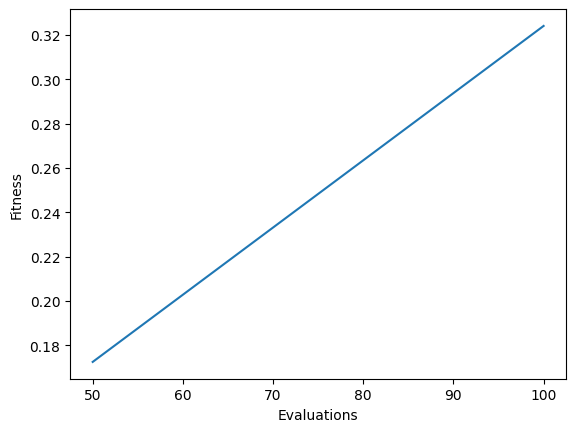

✅ Best agent fitness: 0.3240529792064097


(evaluate_remote pid=23676) /Users/massimodebellisvitti/Desktop/Algorithme evolutionnaire/evolution/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:527: UserWarning: WARN: Using the latest versioned environment `Climber-v2` instead of the unversioned environment `Climber`.
(evaluate_remote pid=23676)   logger.warn(


In [14]:
import json
walker = np.array([
    [0, 0, 0, 0, 0 ],
    [0, 3, 3, 3, 0],
    [0, 3, 3, 3, 0],
    [3, 3, 3, 4, 4],
    [3, 3, 0, 4, 3]
    ])


config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 2, # to change: increase!
    "lambda": 10, # to change: increase!
    "max_steps": 100, # to change to 500
    "seed": None
}

# Run the parallelized CMA-ME
best_agent = CMA_ME(config)
print(f"✅ Best agent fitness: {best_agent.fitness}")

⚠ Nessun seed fornito, generato seed random: 3370
✅ ENV 'Thrower-v0' | Observation dim: 58 | Action dim (network): 6 | Action dim (env): 6


Best: 0.8269699950837505: 100%|██████████| 2/2 [00:38<00:00, 19.34s/it]


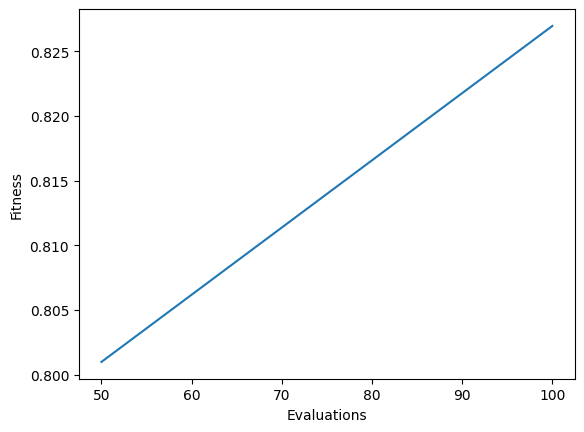

✅ Best agent fitness: 0.8269699950837505


In [15]:
import json
# Define your walker robot
thrower = np.array([
    [0, 0, 1, 0, 0 ],
    [0, 0, 1, 0, 0],
    [0, 4, 3, 4, 2],
    [4, 3, 0, 4, 2],
    [5, 5, 5, 5, 0]
    ])


config = {
    "env_name": "Thrower-v0",
    "robot": thrower,
    "generations": 2, # to change: increase!
    "lambda":10, # Population size
    "max_steps": 500, # to change to 500
    "seed": None
}

# Run the parallelized CMA-ME
best_agent = CMA_ME(config)
print(f"✅ Best agent fitness: {best_agent.fitness}")

⚠ Nessun seed fornito, generato seed random: 5212
✅ ENV 'Climber' | Observation dim: 82 | Action dim (network): 21 | Action dim (env): 21


/Users/massimodebellisvitti/Desktop/Algorithme evolutionnaire/evolution/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:527: UserWarning: WARN: Using the latest versioned environment `Climber-v2` instead of the unversioned environment `Climber`.
  logger.warn(
Best: 0.07697390968010102: 100%|██████████| 1/1 [00:36<00:00, 36.26s/it]


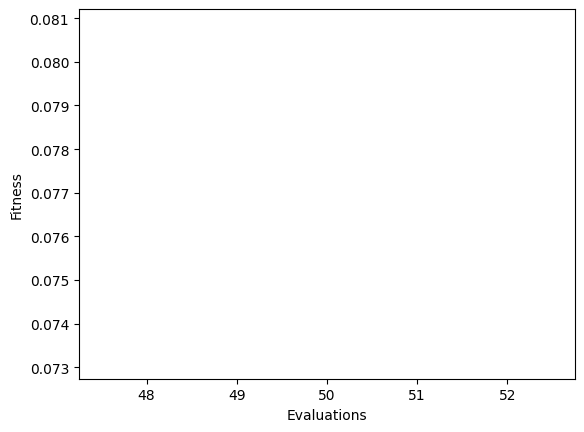

✅ Best agent fitness: 0.07697390968010102


In [16]:
import json
# Define your walker robot
climber = np.array([
    [3, 3, 3, 3, 3 ],
    [0, 4, 3, 4, 0],
    [3, 4, 3, 4, 3],
    [0, 4, 3, 4, 0],
    [3, 3, 3, 3, 3]
    ])


config = {
    "env_name": "Climber",
    "robot": climber,
    "generations": 1, # to change: increase!
    "lambda":10, # Population size
    "max_steps": 500, # to change to 500
    "seed": None
}

# Run the parallelized CMA-ME
best_agent = CMA_ME(config)
print(f"✅ Best agent fitness: {best_agent.fitness}")